In [1]:
!module load python/3.6
import sys
# load your python virtual environment
sys.path.append("/home/u17/jiachuanxu/python3.6_virtualenv/lib/python3.6/site-packages")
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Visualize Correlation Matrix

In [2]:
covs_dir = "/home/u17/jiachuanxu/CosmoLike/DESxPlanck/covs/"
covs_fname = ["cov_y1xplanck_mix6x2pt_referebceMV_bandpower",
              "cov_y1xplanck_mix6x2pt_referebceMV_new", 
              #"cov_y1xplanck_mix6x2pt_tSZdeproj", 
              #"cov_y1xplanck",
              #"cov_y1xplanck_mix6x2pt_tSZcontmdMV"
             ]
covs_data = [np.genfromtxt(covs_dir+cov_fname) for cov_fname in covs_fname]
Ndata_start = []
Ndata_end  = []
Ndata = []
for cov_data in covs_data:
    
    # cov format: bin1, bin2, theta1, theta2, z1, z2, zl, zs, c_g, c_ng
    _Ndata_start, _Ndata_end = int(min(cov_data[:,0])), int(max(cov_data[:,0]))
    _Ndata = _Ndata_end-_Ndata_start+1
    print("covmat file length = {0:d}, Ndata={1:d} ({2:d}-{3:d})".format(cov_data.shape[0], _Ndata,_Ndata_start, _Ndata_end))
    Ndata.append(_Ndata)
    Ndata_start.append(_Ndata_start)
    Ndata_end.append(_Ndata_end)


covmat file length = 609316, Ndata=1094 (0-1093)
covmat file length = 610425, Ndata=1095 (0-1094)


In [3]:
Ntheta = 20
Ncl = 14
Nlens = 5
Nsrc = 4

Nss = Ntheta*( (Nsrc+1)*Nsrc )
Ngs = Ntheta*( Nsrc*Nlens )
Ngg = Ntheta*( Nlens )
Ngk = Ntheta*( Nlens )
Nsk = Ntheta*( Nsrc )
Nkk = Ncl
Ndata_6x2pt = Nss+Ngs+Ngg+Nsk+Ngk+Nkk
Ndata_5x2pt = Nss+Ngs+Ngg+Nsk+Ngk
Ndata_3x2pt = Nss+Ngs+Ngg
print("N6x2pt = %d, N3x2pt = %d"%(Ndata_6x2pt, Ndata_3x2pt))

N6x2pt = 1094, N3x2pt = 900


In [5]:
covs = []
covs_G = []
cors = []
cors_G = []
for ct in range(len(covs_fname)):
    cov = np.zeros((Ndata[ct], Ndata[ct]))
    cov_G = np.zeros((Ndata[ct], Ndata[ct]))
    cov_data = covs_data[ct]
    for line in range(cov_data.shape[0]):
        i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
        cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
        cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
        if(not np.isfinite(cov_data[line, 9])):
            print("NG is not finite: i,j=%d,%d"%(i,j))
        if(not np.isfinite(cov_data[line, 8])):
            print("G is not finite: i,j=%d,%d"%(i,j))
        cov[i, j] = cg + cng
        cov[j, i] = cg + cng
        cov_G[i,j] = cg
        cov_G[j,i] = cg
    cor = np.zeros((Ndata[ct],Ndata[ct]))
    cor_G = np.zeros((Ndata[ct], Ndata[ct]))
    for i in range(0,Ndata[ct]):
        for j in range(0,Ndata[ct]):
            if (cov[i,i]*cov[j,j] >0):
                cor[i,j] = cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])
            if(cov_G[i,i]*cov_G[j,j]>0):
                cor_G[i,j] = cov_G[i,j]/np.sqrt(cov_G[i,i]*cov_G[j,j])
    covs.append(cov)
    cors.append(cor)
    covs_G.append(cov_G)
    cors_G.append(cor_G)

In [6]:
for cor,cov in zip(cors, covs):
    a = np.sort(LA.eigvals(cor[:,:]))
    print("Eigenvalues range of the full correlation matrix: [{}, {}]".format(np.min(a), np.max(a)))
    print("neg eigenvalues full cor:")
    for i in range(0,a.shape[0]):
        if (a[i]< 0.0): print(a[i])
    #print("min/max of cor mat: {}/{}".format(np.min(cor), np.max(cor)))
    a = np.sort(LA.eigvals(cov[:,:]))
    print("Eigenvalues range of the full covmat: [{}, {}]".format(np.min(a), np.max(a)))
    print("neg eigenvalues full covmat:")
    for i in range(0,a.shape[0]):
        if (a[i]< 0.0): print(a[i])

Eigenvalues range of the full correlation matrix: [-3.176775305888678e-07, 32.2308316865542]
neg eigenvalues full cor:
-3.176775305888678e-07
-2.973696079292596e-07
-2.425795616244609e-07
-2.224295752606604e-07
-2.0314193965180958e-07
-1.7841712265748327e-07
-1.493616962637235e-07
-9.461455402625584e-08
-8.703042607846248e-08
-5.966495121653996e-08
-4.759863699320938e-08
-4.1678460686376716e-08
-2.873509398322336e-08
Eigenvalues range of the full covmat: [-4.6508184342621e-13, 0.000796530210654819]
neg eigenvalues full covmat:
-4.6508184342621e-13
-2.709409264589488e-13
-1.1550363223734723e-13
-5.087405498265503e-14
-3.769908401553672e-14
-3.502911589856747e-14
-5.643505489200176e-17
-2.522769956451802e-17
-2.404782358528213e-17
-2.2980426905379917e-17
-2.127381523562965e-17
-9.374141966553118e-18
-7.218557190006126e-18
Eigenvalues range of the full correlation matrix: [-6.090789757930116e-07, 32.193306291389106]
neg eigenvalues full cor:
-6.090789757930116e-07
-5.569373973343856e-07
-

In [7]:
subcov = covs[0][Ndata_3x2pt+Ngk:Ndata_5x2pt, Ndata_3x2pt+Ngk:Ndata_5x2pt]
print(subcov.shape)
a = np.sort(LA.eigvals(subcov[:,:]))
print("Eigenvalues range of the full covmat: [{}, {}]".format(np.min(a), np.max(a)))
print("neg eigenvalues full covmat:")
for i in range(0,a.shape[0]):
    if (a[i]< 0.0): print(a[i])

(80, 80)
Eigenvalues range of the full covmat: [-5.64308232322092e-17, 1.7198016697547627e-09]
neg eigenvalues full covmat:
-5.64308232322092e-17
-2.527209605681525e-17
-2.4048944201538848e-17
-2.2975697680396953e-17
-2.130327381741408e-17
-9.490425612300375e-18
-7.221511099286761e-18


max_range = 3.488350e-02
Bbox(x0=0.135, y0=0.125, x1=1.025, y1=1.005)
Bbox(x0=0.135, y0=0.125, x1=1.025, y1=1.005)
Bbox(x0=0.14, y0=0.05, x1=1.02, y1=0.12000000000000001)


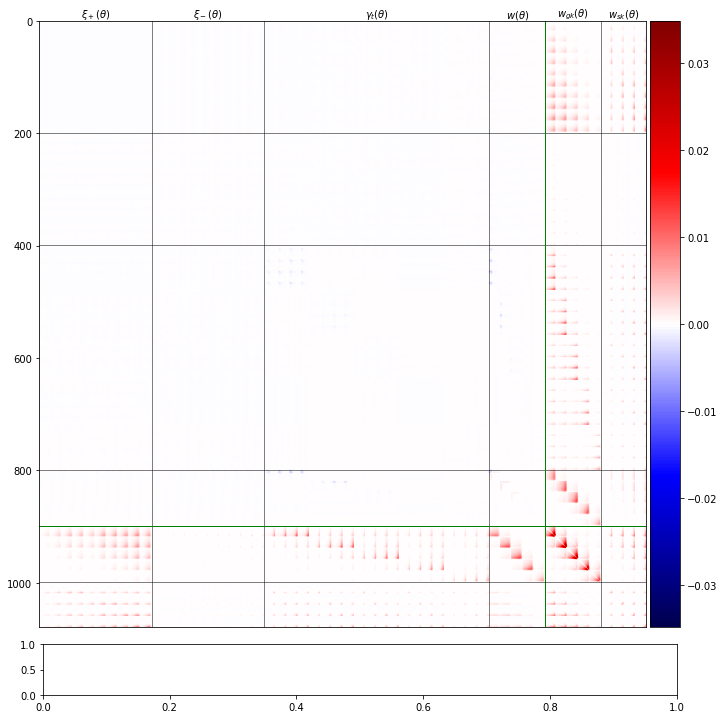

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.135, 0.125, 0.89, 0.88])

data_to_show = (cors[0][:Ndata_5x2pt,:Ndata_5x2pt] - cors[1][:Ndata_5x2pt,:Ndata_5x2pt])
max_range = np.max(abs(data_to_show))
print("max_range = %e"%max_range)
cb = ax.imshow(data_to_show, origin="upper", cmap='seismic', 
    vmin=-max_range,vmax=max_range,
    #vmin=-0.1e-16, vmax=0.1e-16
    #vmin=-1.1e-12, vmax=1.1e-12
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(cb, cax=cax)

print(ax.get_position())
subax = fig.add_axes([0.14, 0.05, 0.88, 0.07])
#ax = plt.gca()
print(ax.get_position())
print(subax.get_position())
# xi_+
ax.axvline(Nss/2-0.5, lw=0.5, color='k')
ax.axhline(Nss/2-0.5, lw=0.5, color='k')
# xi_-
ax.axvline(Nss-0.5, lw=0.5, color='k')
ax.axhline(Nss-0.5, lw=0.5, color='k')
# gs
ax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs-0.5, lw=0.5, color='k')
# gg
ax.axvline(Nss+Ngs+Ngg-0.5, lw=1, color='g')
ax.axhline(Nss+Ngs+Ngg-0.5, lw=1, color='g')
# gk
ax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
# sk
ax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=1, color='g')
ax.axhline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=1, color='g')

ax.text(Nss/2/2, 0, r'$\xi_+(\theta)$', ha='center', va='bottom')
ax.text((Nss/2 + Nss)/2, 0, r'$\xi_-(\theta)$', ha='center', va='bottom')
ax.text((Nss + Nss+Ngs)/2, 0, r'$\gamma_t(\theta)$', ha='center', va='bottom')
ax.text((Nss+Ngs + Nss+Ngs+Ngg)/2, 0, r'$w(\theta)$', ha='center', va='bottom')
ax.text((Ndata_3x2pt + Ndata_3x2pt+Ngk)/2, 0, r'$w_{gk}(\theta)$', ha='center', va='bottom')
ax.text((Ndata_3x2pt+Ngk + Ndata_3x2pt+Ngk+Nsk)/2, 0, r'$w_{sk}(\theta)$', ha='center', va='bottom')
#ax.text((Ndata_3x2pt+Ngk+Nsk + Ndata_6x2pt)/2, -4, r'$C_{kk}(\ell)$', ha='center', va='bottom')
ax.set_xticks([])

show_datav_diff = False
if show_datav_diff:
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                   s=1, label='tSZcontm-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff_tSZref[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                  s=1, label='ref-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[:Ndata_3x2pt], diff_treecorr[:Ndata_3x2pt], 
                  s=1, label='TreeCorr-Pub')
    subax.legend(loc='lower left')
    # xi_+
    subax.axvline(Nss/2-0.5, lw=0.5, color='k')
    # xi_-
    subax.axvline(Nss-0.5, lw=0.5, color='k')
    # gs
    subax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
    # gg
    subax.axvline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
    # gk
    subax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
    # sk
    subax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')
    subax.set_xlim(ax.get_xlim())


plt.show()

In [122]:
diff = cors[0][:Ndata_3x2pt,:Ndata_3x2pt] - cors[1][:Ndata_3x2pt,:Ndata_3x2pt]
print(f'correlation matrix residuals in [{np.min(diff)}, {np.max(diff)}]')
diff = covs[0][:Ndata_5x2pt,:Ndata_5x2pt] - covs[1][:Ndata_5x2pt,:Ndata_5x2pt]
print(f'covariance matrix residuals in [{np.min(diff)}, {np.max(diff)}]')

correlation matrix residuals in [-0.0037467314019952874, 0.0019701907616568315]
covariance matrix residuals in [-1.1617299999999947e-06, 5.535000000000278e-08]


## TODO: 
- [ ] why there's difference in the 3x2pt part?
- [ ] compare between Planck covmat and analytical covmat

## CMB lensing convergence covmat: compare between Planck DR and CosmoLike

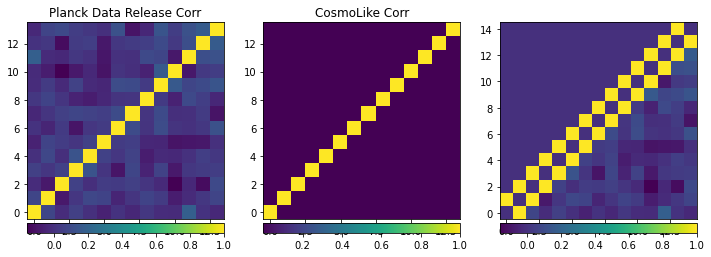

In [123]:
cov_merge = np.zeros((15,15))
cor_merge = np.zeros((15,15))

cov_kk_cosmolike = covs[0][Ndata_5x2pt:, Ndata_5x2pt:]
#cov_kk_cosmolike.shape
cov_kk_planck = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/PlanckLensingLikelihood/smicadx12_Dec5_ftl_mv2_ndclpttptt_p_teb_agr2_CMBmarged.dataset_EXTRACT/covariance.txt").reshape((14,14))
#cov_kk_planck.shape

cor_kk_cosmolike = np.zeros((14,14))
cor_kk_planck = np.zeros((14,14))
for i in range(14):
    for j in range(14):
        if cov_kk_cosmolike[i,i]*cov_kk_cosmolike[j,j] > 0:
            cor_kk_cosmolike[i,j] = cov_kk_cosmolike[i,j]/np.sqrt(cov_kk_cosmolike[i,i]*cov_kk_cosmolike[j,j])
        if cov_kk_planck[i,i]*cov_kk_planck[j,j] > 0:
            cor_kk_planck[i,j] = cov_kk_planck[i,j]/np.sqrt(cov_kk_planck[i,i]*cov_kk_planck[j,j])

for i in range(15):
    for j in range(15):
        if j > i: # right half, planck
            cov_merge[i,j] = cov_kk_planck[i, j-1]
            cor_merge[i,j] = cor_kk_planck[i, j-1]
        elif j < i: # left half, cosmolike
            cov_merge[i,j] = cov_kk_cosmolike[i-1, j]
            cor_merge[i,j] = cor_kk_cosmolike[i-1, j]

fig, axes = plt.subplots(1,3, figsize=(12,4))

cb = axes[0].imshow(cor_kk_planck, origin='lower')
axes[0].set_title('Planck Data Release Corr')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[1].imshow(cor_kk_cosmolike, origin='lower')
axes[1].set_title("CosmoLike Corr")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[2].imshow(cor_merge, origin='lower')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

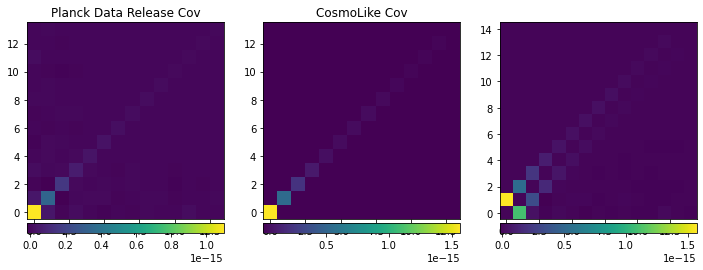

In [124]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

cb = axes[0].imshow(cov_kk_planck, origin='lower')
axes[0].set_title('Planck Data Release Cov')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[1].imshow(cov_kk_cosmolike, origin='lower')
axes[1].set_title("CosmoLike Cov")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[2].imshow(cov_merge, origin='lower')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

Text(0, 0.5, 'Planck/CosmoLike - 1')

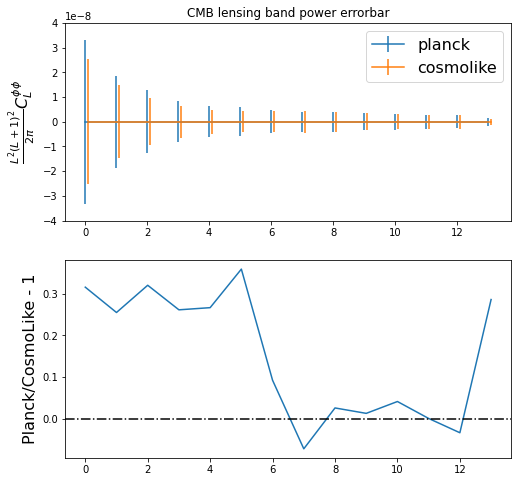

In [155]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

axes[0].errorbar(np.array(range(14)), np.zeros(14), yerr=np.sqrt(np.diagonal(cov_kk_planck)), label='planck')
axes[0].errorbar(np.array(range(14))+0.1, np.zeros(14), yerr=2/np.pi*np.sqrt(np.diagonal(cov_kk_cosmolike)), label='cosmolike')
axes[0].set_ylim([-4e-8, 4e-8])
axes[0].legend(fontsize=16)
axes[0].set_title("CMB lensing band power errorbar")
axes[0].set_ylabel(r'$\frac{L^2(L+1)^2}{2\pi}C^{\phi\phi}_L$', fontsize=16)

axes[1].plot(range(14), np.sqrt(np.diagonal(cov_kk_planck))/(2/np.pi*np.sqrt(np.diagonal(cov_kk_cosmolike)))-1,)
axes[1].axhline(0,ls='-.',c='k')
axes[1].set_ylabel('Planck/CosmoLike - 1', fontsize=16)

[9.9744980472988e-16, 3.4580609333071077e-16, 1.4473447762424894e-16, 6.667320402705474e-17, 3.810398672093528e-17, 3.052129195946636e-17, 2.859818245797362e-17, 2.83489326954189e-17, 2.4503149901450828e-17, 1.756026875373903e-17, 1.5188792434026332e-17, 1.3468083344862064e-17, 1.1727245252387478e-17, 2.59581352550872e-18]
[1.1028173710875626e-15, 3.4595640251057883e-16, 1.5981256507162764e-16, 6.896010863372863e-17, 3.8151396016657005e-17, 3.2777862956381686e-17, 2.2380643778432357e-17, 1.651856913816714e-17, 1.5606374570240894e-17, 1.2126860731086323e-17, 9.581179621648081e-18, 7.38752539918432e-18, 6.36384358916372e-18, 2.3233798254947303e-18]


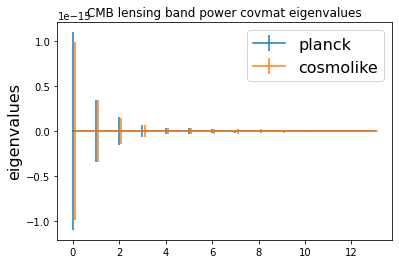

In [142]:
eigvals_kk_cosmolike = sorted(np.linalg.eigvals(2/np.pi*cov_kk_cosmolike), reverse=True)
eigvals_kk_planck = sorted(np.linalg.eigvals(cov_kk_planck), reverse=True)

plt.errorbar(np.array(range(14)), np.zeros(14), yerr=eigvals_kk_planck, label='planck')
plt.errorbar(np.array(range(14))+0.1, np.zeros(14), yerr=eigvals_kk_cosmolike, label='cosmolike')
#plt.ylim([-4e-8, 4e-8])
plt.legend(fontsize=16)
plt.title("CMB lensing band power covmat eigenvalues")
plt.ylabel("eigenvalues", fontsize=16)
print(eigvals_kk_cosmolike)
print(eigvals_kk_planck)

# Covariance matrix inverse

In [15]:
invcov = LA.inv(cov)
a = np.sort(LA.eigvals(invcov[:,:]))
print("Eigenvalues range of the full invcov matrix: [{}, {}]".format(np.min(a), np.max(a)))
print("neg eigenvalues full invcov:")
for i in range(0,a.shape[0]):
    if (a[i]< 0.0): print(a[i])

Eigenvalues range of the full invcov matrix: [-3.02529240108774e+17, 1.1935301806862992e+17]
neg eigenvalues full invcov:
-3.02529240108774e+17
-1.7380148719713088e+17
-1.0899146021286371e+17
-3.003518766019656e+16
-1.4219757166158308e+16
-1.133614744582977e+16
-1.0408383542583398e+16
-152541069300632.8
-65286561056497.14
-17654489365148.74
-12964328221201.148
-2208408988185.1953


# Check likelihood difference between data vectors

In [105]:
# 2pt functions output
twopt_dir = "/home/u17/jiachuanxu/CosmoLike/2pt_measurements/data_test"

# data vector angular mask file


# 3x2pt data vectors measured by TreeCorr
datav_gg = twopt_dir+'/gg_%d_%d.txt'
datav_gs = twopt_dir+'/ggl_S%d_L%d.txt'
datav_ss = twopt_dir+'/shear_%d_%d.txt'

# gk, sk data vectors measured from planck reference smoothed map
datav_gk_tSZref = twopt_dir+'/gk_smooth_%d.txt'
datav_sk_tSZref = twopt_dir+'/sk_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-contaminated smoothed map
datav_gk_tSZcontm = twopt_dir+'/gk_SZctm_smooth_%d.txt'
datav_sk_tSZcontm = twopt_dir+'/sk_SZctm_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-deprojected smoothed map
datav_gk_tSZdeproj = twopt_dir+'/gk_SZdeproj_smooth_%d.txt'
datav_sk_tSZdeproj = twopt_dir+'/sk_SZdeproj_smooth_%d.txt'

In [127]:
gk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          ]
sk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
          ]
_DESY1_3x2pt_mask = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/2pt_meas"\
                                 "urements/data_test/xi_desy1_3x2pt_treecorr_test.mask")
DESY1_3x2pt_mask = np.zeros(Ndata)
DESY1_3x2pt_mask[:Ndata_3x2pt] = _DESY1_3x2pt_mask[:,1]

## 1. 6x2pt Data vector measured using Planck reference map and Planck tSZ-deprojected map

In [111]:
datav_tSZcontm = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZcontm = np.genfromtxt(datav_gk_tSZcontm%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = gk_tSZcontm['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZcontm = np.genfromtxt(datav_sk_tSZcontm%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = sk_tSZcontm['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff = datav_tSZcontm - datav_tSZdeproj
loglike_diff = -0.5*diff.T@invcov@diff
print("Difference in log(likelihood) between tSZ-contamintaed "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between tSZ-contaminated and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between tSZ-contamintaed and tSZ-deprojected gk+sk data vectors = -426.76
Difference in chi2 per dof between tSZ-contaminated and tSZ-deprojected gk+sk data vectors >= 4.74


## 2. 3x2pt Data vector measured using TreeCorr code and the public data vector

In [128]:
datav_treecorr = np.zeros(Ndata)
datav_public = np.zeros(Ndata)
_datav_treecorr = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_treecorr_test")
_datav_public = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_public")
datav_treecorr[0:Ndata_3x2pt] = _datav_treecorr[:,1]
datav_public[0:Ndata_3x2pt] = _datav_public[:,1]
# calculate difference in likelihood
diff_treecorr = (datav_treecorr - datav_public)*DESY1_3x2pt_mask
loglike_diff = -0.5*diff_treecorr.T@invcov@diff_treecorr
print("Difference in log(likelihood) between TreeCorr "\
      "and Public 3x2pt data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between TreeCorr and"\
      " public 3x2pt data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

Difference in log(likelihood) between TreeCorr and Public 3x2pt data vectors = -2.42
Difference in chi2 per dof between TreeCorr and public 3x2pt data vectors >= 0.03


In [112]:
datav_tSZref = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZref = np.genfromtxt(datav_gk_tSZref%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = gk_tSZref['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZref = np.genfromtxt(datav_sk_tSZref%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = sk_tSZref['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff_tSZref = datav_tSZref - datav_tSZdeproj
loglike_diff = -0.5*diff_tSZref.T@invcov@diff_tSZref
print("Difference in log(likelihood) between reference "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between reference and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between reference and tSZ-deprojected gk+sk data vectors = -559.73
Difference in chi2 per dof between reference and tSZ-deprojected gk+sk data vectors >= 6.22


In [ ]:
2.5-250 arcmin